Вам нужно проанализировать биоинформатический датасет (ссылка на скачивание) по пространственной транскриптомике (дополнительная информация по теме) пациентов с плоскоклеточным раком. В нем клетки (колонка cell_type) объединены в микроокружения (колонка cell_interaction) в зависимости от взаимодействия этих клеток. Вашей основной задачей будет поиск отличий в организации микроокружения у пожилых и молодых пациентов (колонка age_group).

Также в датасете есть следующие колонки:

distance_to_vasculature — расстояние до ближайших сосудов;

distance_to_largest_cell — расстояние до ближайшей крупной клетки;

immune_marker_1 — экспрессия иммунного маркера 1 в данной клетке;

immune_marker_2 — экспрессия иммунного маркера 2 в данной клетке;

cell_type — тип клетки;

area_of_cell — размер клетки;

case_id — уникальный ID пациента.

In [1]:
# Загрузим библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from statannot import add_stat_annotation
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import bootstrap
from scipy.stats import spearmanr

In [2]:
# Подготовка датасета

dataset = pd.read_csv('asset-v1_SkillFactory+MFTIBIO+SEP2023+type@asset+block@community_dataset.csv')


In [3]:
dataset.head()

,distance_to_vasculature,distance_to_largest_cell,immune_marker_1,immune_marker_2,cell_interaction,cell_type,case_id,area_of_cell,age_group
0,988.509380,612.076506,10.803755,187.998971,community_1,Stroma cells,891.0,185.0,elder_group
1,787.852379,637.787202,11.749179,155.357076,community_1,Stroma cells,891.0,209.0,elder_group
2,960.635580,700.283468,15.124372,182.626888,community_2,Stroma cells,891.0,254.0,elder_group
3,702.033032,676.409695,14.221883,158.381917,community_3,Unclassified,891.0,156.0,elder_group
4,830.399371,863.269930,19.978977,159.071269,community_3,Unclassified,891.0,194.0,elder_group


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126474 entries, 0 to 126473
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   distance_to_vasculature   126474 non-null  float64
 1   distance_to_largest_cell  126474 non-null  float64
 2   immune_marker_1           126474 non-null  float64
 3   immune_marker_2           126474 non-null  float64
 4   cell_interaction          126474 non-null  object 
 5   cell_type                 126473 non-null  object 
 6   case_id                   126473 non-null  float64
 7   area_of_cell              126473 non-null  float64
 8   age_group                 126473 non-null  object 
dtypes: float64(6), object(3)
memory usage: 8.7+ MB


In [5]:
dataset.isnull().sum()

distance_to_vasculature     0
distance_to_largest_cell    0
immune_marker_1             0
immune_marker_2             0
cell_interaction            0
cell_type                   1
case_id                     1
area_of_cell                1
age_group                   1
dtype: int64

In [6]:
dataset['case_id'].isnull()

0         False
1         False
2         False
3         False
4         False
          ...  
126469    False
126470    False
126471    False
126472    False
126473     True
Name: case_id, Length: 126474, dtype: bool

В датасете есть пропуски.

In [7]:
print(dataset.iloc[126473])

distance_to_vasculature      983.369885
distance_to_largest_cell     692.159612
immune_marker_1               28.080539
immune_marker_2              151.589357
cell_interaction            community_4
cell_type                           NaN
case_id                             NaN
area_of_cell                        NaN
age_group                           NaN
Name: 126473, dtype: object


Последняя строка заполнена частично.

In [8]:
# Удаляем последнюю строку
dataset=dataset.drop(dataset.index[126473])

In [9]:
dataset.isnull().sum()

distance_to_vasculature     0
distance_to_largest_cell    0
immune_marker_1             0
immune_marker_2             0
cell_interaction            0
cell_type                   0
case_id                     0
area_of_cell                0
age_group                   0
dtype: int64

In [10]:
# Проверка на дубликаты
dataset.duplicated().any()

False

In [11]:
# Статистика по  столбцам
dataset.describe()

,distance_to_vasculature,distance_to_largest_cell,immune_marker_1,immune_marker_2,case_id,area_of_cell
count,126473.000000,126473.000000,126473.000000,126473.000000,126473.000000,126473.000000
mean,928.738260,763.818859,20.199625,77.693380,535.593961,252.513295
std,232.505721,143.782977,8.895994,62.432115,340.024171,156.473940
min,576.003599,576.000505,0.022423,0.078416,40.000000,52.000000
25%,748.249636,666.300991,14.074053,32.202712,199.000000,180.000000
50%,888.373046,731.617873,19.181260,53.401991,693.000000,229.000000
75%,1067.789887,822.036289,24.958793,114.898690,708.000000,295.000000
max,2057.201309,3167.356219,110.072007,1231.730994,983.000000,6807.000000


In [12]:
# Статистика по категориальным столбцам
# data.describe(exclude=['float64'])
dataset.describe(include=['object'])

,cell_interaction,cell_type,age_group
count,126473,126473,126473
unique,6,8,2
top,community_4,Stroma cells,young_group
freq,37405,80840,87644


In [13]:
dataset['cell_interaction'].value_counts()

cell_interaction
community_4    37405
community_2    24108
community_1    22842
community_5    16564
community_6    12840
community_3    12714
Name: count, dtype: int64

In [14]:
# Добавим числовой столбец cell_interaction_digit
dataset['cell_interaction_digit'] = dataset['cell_interaction'].map({
    'community_4': 4,
    'community_2': 2,
    'community_1': 1,
    'community_5': 5,
    'community_6': 6,
    'community_3': 3
})

In [15]:
dataset['cell_interaction_digit'].value_counts()

cell_interaction_digit
4    37405
2    24108
1    22842
5    16564
6    12840
3    12714
Name: count, dtype: int64

In [16]:
dataset['cell_type'].value_counts()

cell_type
Stroma cells     80840
Unclassified     31772
Immune type 2     7676
Immune type 1     2636
Blood cells       1342
Bone cells        1235
Largest cells      902
Vasculature         70
Name: count, dtype: int64

In [17]:
dataset['age_group'].value_counts()

age_group
young_group    87644
elder_group    38829
Name: count, dtype: int64

In [18]:
dataset['age_group'] = dataset['age_group'].map({
    'young_group': 0,
    'elder_group': 1
})

In [19]:
dataset.describe()

,distance_to_vasculature,distance_to_largest_cell,immune_marker_1,immune_marker_2,case_id,area_of_cell,age_group,cell_interaction_digit
count,126473.000000,126473.000000,126473.000000,126473.000000,126473.000000,126473.000000,126473.000000,126473.000000
mean,928.738260,763.818859,20.199625,77.693380,535.593961,252.513295,0.307014,3.310430
std,232.505721,143.782977,8.895994,62.432115,340.024171,156.473940,0.461257,1.596886
min,576.003599,576.000505,0.022423,0.078416,40.000000,52.000000,0.000000,1.000000
25%,748.249636,666.300991,14.074053,32.202712,199.000000,180.000000,0.000000,2.000000
50%,888.373046,731.617873,19.181260,53.401991,693.000000,229.000000,0.000000,4.000000
75%,1067.789887,822.036289,24.958793,114.898690,708.000000,295.000000,1.000000,4.000000
max,2057.201309,3167.356219,110.072007,1231.730994,983.000000,6807.000000,1.000000,6.000000


Датасет готов к работе

### Задачи

#### 1) Есть ли стат-значимость между типом клетки и:

а) Размером клетки (area_of_cell), добавьте hue по возрастным группам.

б) Экспрессией иммунных маркеров (immune_marker_1, immune_marker_2), добавьте hue по возрастным группам.

в) Дистанцией до ближайших объектов (distance_to_vasculature, distance_to_largest_cell), добавьте hue по возрастным группам.

В качестве ответов можно приводить box_plot/swarplot, где по одной оси будет тип клеток, а по другой — оцениваемая вами статистика.

In [20]:
data1 = dataset.copy()
test_param = 'area_of_cell'

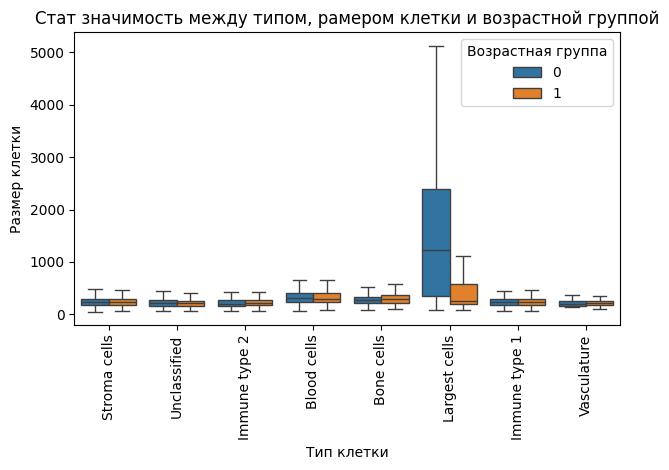

In [21]:
sns.boxplot(
    data= data1,
    x= 'cell_type',
    y= 'area_of_cell',
    hue= 'age_group',
    showfliers= False
)

plt.title('Стат значимость между типом, рамером клетки и возрастной группой')
plt.xlabel('Тип клетки')
plt.ylabel('Размер клетки')
plt.legend(title='Возрастная группа')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

У молодых пациентов размер клеток больше по сравнению с возрастными.

In [22]:
sub_young = data1[ data1['age_group'] == 0][['area_of_cell', 'cell_type']]

sub_young.head()

,area_of_cell,cell_type
315,261.0,Stroma cells
316,142.0,Immune type 2
317,344.0,Stroma cells
318,170.0,Stroma cells
319,224.0,Immune type 1


In [23]:
sub_elder = data1[ data1['age_group'] == 1][['area_of_cell', 'cell_type']]

sub_elder.head()

,area_of_cell,cell_type
0,185.0,Stroma cells
1,209.0,Stroma cells
2,254.0,Stroma cells
3,156.0,Unclassified
4,194.0,Unclassified


In [24]:
# Тест на нормальное распределение
def normality_test(dataset, column, alpha=0.05):
    lines = dataset['cell_type'].unique()   
    H0 = 'Распределение {} нормальное'
    H1 = 'Распределение {} отлично от нормального.'
    for line in lines:
        data = dataset[dataset['cell_type'] == line][column]
        
        __, p_value = shapiro(data)
        if p_value < alpha:
            print('Нулевая гипотеза отвергнута. {}'.format(H1.format(line)))
        else:
            print('Принята нулевая гипотеза: {}'.format(H0.format(line)))

In [25]:
normality_test(sub_young, test_param)

Нулевая гипотеза отвергнута. Распределение Stroma cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Immune type 2 отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Immune type 1 отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Unclassified отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Largest cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Blood cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Bone cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Vasculature отлично от нормального.


C:\Users\GrafGAD\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [26]:
normality_test(sub_elder, test_param)

Нулевая гипотеза отвергнута. Распределение Stroma cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Unclassified отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Immune type 2 отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Blood cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Bone cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Largest cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Immune type 1 отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Vasculature отлично от нормального.


Наши данные распределены не нормально.

In [61]:
# Тест на гомогенность
        
def homogeneity_test(dataset, column, alpha=0.05):
    lines = dataset['cell_type'].unique()   
    H0 = 'Распределение гомогенное.'
    H1 = 'Распределение отлично от гомогенного.' 
    data = []
    for line in lines:
        data.append(dataset.loc[dataset['cell_type'] == line, column])
        
    __, p = levene(*data)
    if p < alpha:
        print('Нулевая гипотеза отвергнута. {}'.format(H1))
    else:
        print('p = {}'.format(p))
        print('Принята нулевая гипотеза: {}'.format(H0.format(line)))

In [28]:
homogeneity_test(sub_young, test_param)

Нулевая гипотеза отвергнута. Распределение отлично от гомогенного.


In [29]:
homogeneity_test(sub_elder, test_param)

Нулевая гипотеза отвергнута. Распределение отлично от гомогенного.


In [30]:
# Размеры выборок
print('Размер молодой выборки: {}'.format(sub_young.shape))
print('Размер возрастной выборки: {}'.format(sub_elder.shape))

Размер молодой выборки: (87644, 2)
Размер возрастной выборки: (38829, 2)


Выводы:

Данные распределены ненормально и негомогенно.
Выборки не связаны между собой.
Размер выборки достаточный (молодые - 87644 и возрастные - 38829)
Имеются выбросы.

Таким образом, нужен непараметрический теста, малочувствительный к выбросам. Тест Краскула-Уолиса.

In [31]:
# Тест Краскула-Уолиса

def kruskal_test(dataset, column, alpha=0.05):
    lines = dataset['cell_type'].unique()   
    H0 = 'Разница между группами статистически не значима.'
    H1 = 'Разница между группами статистически значима.' 
    data = []
    for line in lines:
        data.append(dataset.loc[dataset['cell_type'] == line, column])
        
    __, p = kruskal(*data)
    if p < alpha:
        print('Нулевая гипотеза отвергнута. {}'.format(H1))
    else:
        print('Принята нулевая гипотеза: {}'.format(H0.format(line)))

In [32]:
kruskal_test(sub_young, test_param)

Нулевая гипотеза отвергнута. Разница между группами статистически значима.


In [33]:
kruskal_test(sub_elder, test_param)

Нулевая гипотеза отвергнута. Разница между группами статистически значима.


Вывод:

В обеих группах мтатистически занчимая разница между размерами клетки и ее типом.

In [34]:
# Расчет доверительных интервалов

def compute_confidence_intervals(data, column_group, column_data, confidence_level=0.95, n_resamples=100):
    groups = data[column_group].unique()

    for group in groups:
        group_data = data[data[column_group] == group][column_data].to_numpy()

        if len(group_data) > 1:
            confidence_interval = bootstrap((group_data,), np.median,
                                            method='percentile',
                                            confidence_level=confidence_level,
                                            n_resamples=n_resamples).confidence_interval
            
            formatted_interval = f"[{confidence_interval.low:.2f}, {confidence_interval.high:.2f}]"
            print(
                f"Тип клеток: {group}, {confidence_level*100:.0f}% доверительный интервал для медианы: {formatted_interval}")
        
        else:
            print(
                f"Тип клеток: {group}, не достаточно данных для расчета доверителеьного интервала.")

In [35]:
compute_confidence_intervals(sub_young, 'cell_type', 'area_of_cell')

Тип клеток: Stroma cells, 95% доверительный интервал для медианы: [238.00, 240.00]
Тип клеток: Immune type 2, 95% доверительный интервал для медианы: [203.00, 210.00]
Тип клеток: Immune type 1, 95% доверительный интервал для медианы: [222.00, 230.00]
Тип клеток: Unclassified, 95% доверительный интервал для медианы: [213.00, 215.00]
Тип клеток: Largest cells, 95% доверительный интервал для медианы: [959.88, 1503.17]
Тип клеток: Blood cells, 95% доверительный интервал для медианы: [305.00, 320.00]
Тип клеток: Bone cells, 95% доверительный интервал для медианы: [268.00, 278.52]
Тип клеток: Vasculature, 95% доверительный интервал для медианы: [177.00, 242.00]


В выборке с молодыми пациентами доверительный интервал клеток Vasculature шире и пересекается с несколькими другими типами клеток. Остальные интервале не пересекаются между собой. Размеры клеток Largest cells в несколько раз отличаются от остальных и имеются самы большой доверительный интервал.

In [36]:
compute_confidence_intervals(sub_elder, 'cell_type', 'area_of_cell')

Тип клеток: Stroma cells, 95% доверительный интервал для медианы: [225.00, 229.00]
Тип клеток: Unclassified, 95% доверительный интервал для медианы: [209.00, 212.05]
Тип клеток: Immune type 2, 95% доверительный интервал для медианы: [216.00, 221.26]
Тип клеток: Blood cells, 95% доверительный интервал для медианы: [288.00, 319.67]
Тип клеток: Bone cells, 95% доверительный интервал для медианы: [266.95, 316.52]
Тип клеток: Largest cells, 95% доверительный интервал для медианы: [244.47, 279.57]
Тип клеток: Immune type 1, 95% доверительный интервал для медианы: [226.90, 243.00]
Тип клеток: Vasculature, 95% доверительный интервал для медианы: [186.95, 223.62]


В выборке с возрастными пациентами доверительный интервал клеток Vasculature шире и пересекается с несколькими другими типами клеток. Остальные интервале не пересекаются между собой. Largest cells не выделяются по сравнению с молодоц группой.

### Задание 1б

Есть ли стат-значимость между типом клетки и экспрессией иммунных маркеров (immune_marker_1, immune_marker_2), добавьте hue по возрастным группам.

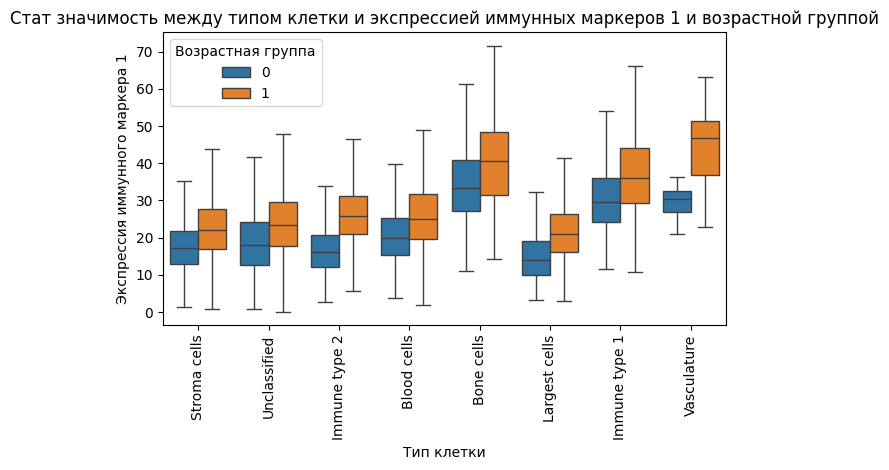

In [37]:
sns.boxplot(
    data= data1,
    x= 'cell_type',
    y= 'immune_marker_1',
    hue= 'age_group',
    showfliers= False
)

plt.title('Стат значимость между типом клетки и экспрессией иммунных маркеров 1 и возрастной группой')
plt.xlabel('Тип клетки')
plt.ylabel('Экспрессия иммунного маркера 1')
plt.legend(title='Возрастная группа')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Костные клетки, клетки иммунного типа 1 и vasculature в среднем имеют большую укспрессию имменного маркера 1. У пожилых тенденция прослеживается сильнее.

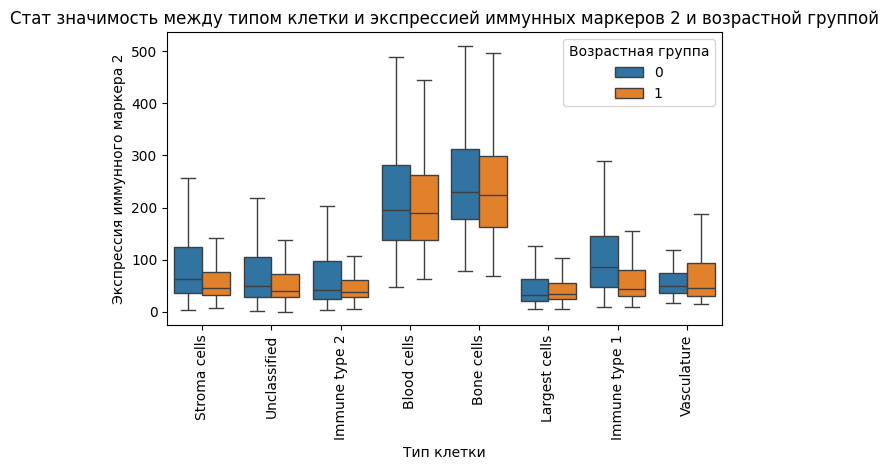

In [38]:
sns.boxplot(
    data= data1,
    x= 'cell_type',
    y= 'immune_marker_2',
    hue= 'age_group',
    showfliers= False
)

plt.title('Стат значимость между типом клетки и экспрессией иммунных маркеров 2 и возрастной группой')
plt.xlabel('Тип клетки')
plt.ylabel('Экспрессия иммунного маркера 2')
plt.legend(title='Возрастная группа')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Кровяные и костные клетки в среднем имеют высокую экспрессию имменного маркера 2 в обеих возрастных группах.

In [39]:
# Создадим сабсеты для каждой возрастной группы и иммунного маркера

young_marker_1 = data1[data1['age_group'] == 0][['immune_marker_1', 'cell_type']]
young_marker_2 = data1[data1['age_group'] == 0][['immune_marker_2', 'cell_type']]
elder_marker_1 = data1[data1['age_group'] == 1][['immune_marker_1', 'cell_type']]
elder_marker_2 = data1[data1['age_group'] == 1][['immune_marker_2', 'cell_type']]

In [40]:
normality_test(young_marker_1, 'immune_marker_1')

Нулевая гипотеза отвергнута. Распределение Stroma cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Immune type 2 отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Immune type 1 отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Unclassified отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Largest cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Blood cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Bone cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Vasculature отлично от нормального.


C:\Users\GrafGAD\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [41]:
normality_test(young_marker_2, 'immune_marker_2')

Нулевая гипотеза отвергнута. Распределение Stroma cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Immune type 2 отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Immune type 1 отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Unclassified отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Largest cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Blood cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Bone cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Vasculature отлично от нормального.


In [42]:
normality_test(elder_marker_1, 'immune_marker_1')

Нулевая гипотеза отвергнута. Распределение Stroma cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Unclassified отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Immune type 2 отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Blood cells отлично от нормального.
Принята нулевая гипотеза: Распределение Bone cells нормальное
Нулевая гипотеза отвергнута. Распределение Largest cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Immune type 1 отлично от нормального.
Принята нулевая гипотеза: Распределение Vasculature нормальное


In [43]:
normality_test(elder_marker_2, 'immune_marker_2')

Нулевая гипотеза отвергнута. Распределение Stroma cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Unclassified отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Immune type 2 отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Blood cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Bone cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Largest cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Immune type 1 отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Vasculature отлично от нормального.


Распределение имменного марекра 1 в Vasculature и Bone cells у возрастных пациентов нормальное.

Все остальные распределения ненормальные.

In [44]:
# Проверка гомогенности дисперсий

homogeneity_test(young_marker_1, 'immune_marker_1')
homogeneity_test(young_marker_2, 'immune_marker_2')
homogeneity_test(elder_marker_1, 'immune_marker_1')
homogeneity_test(elder_marker_2, 'immune_marker_2')


Нулевая гипотеза отвергнута. Распределение отлично от гомогенного.


Нулевая гипотеза отвергнута. Распределение отлично от гомогенного.
Нулевая гипотеза отвергнута. Распределение отлично от гомогенного.
Нулевая гипотеза отвергнута. Распределение отлично от гомогенного.


Во всех выборках данные распределены негомогенно.

In [45]:
# Размеры выборок

print('Размер молодой выборки с иммунным маркером 1: {}'.format(sub_young.shape))
print('Размер молодой выборки с иммунным маркером 2: {}'.format(sub_elder.shape))
print('Размер возрастной выборки с иммунным маркером 1: {}'.format(sub_young.shape))
print('Размер возрастной выборки с иммунным маркером 2: {}'.format(sub_elder.shape))


Размер молодой выборки с иммунным маркером 1: (87644, 2)
Размер молодой выборки с иммунным маркером 2: (38829, 2)
Размер возрастной выборки с иммунным маркером 1: (87644, 2)
Размер возрастной выборки с иммунным маркером 2: (38829, 2)


##### Выводы:

Данные распределены ненормально и негомогенно.

Выборки не связаны между собой по возрасту, но связаны по маркерам - оба маркера взяты у одного и тогоже пациента.

Размер выборки достаточный (молодые - 87644 и возрастные - 38829)

Имеются выбросы.

Таким образом, нужен непараметрический теста, малочувствительный к выбросам. Тест Краскула-Уолиса.

In [46]:
kruskal_test(young_marker_1, 'immune_marker_1')
kruskal_test(young_marker_2, 'immune_marker_2')
kruskal_test(elder_marker_1, 'immune_marker_1')
kruskal_test(elder_marker_2, 'immune_marker_2')

Нулевая гипотеза отвергнута. Разница между группами статистически значима.
Нулевая гипотеза отвергнута. Разница между группами статистически значима.
Нулевая гипотеза отвергнута. Разница между группами статистически значима.
Нулевая гипотеза отвергнута. Разница между группами статистически значима.


In [47]:
compute_confidence_intervals(young_marker_1, 'cell_type', 'immune_marker_1')

Тип клеток: Stroma cells, 95% доверительный интервал для медианы: [17.24, 17.37]
Тип клеток: Immune type 2, 95% доверительный интервал для медианы: [15.98, 16.49]
Тип клеток: Immune type 1, 95% доверительный интервал для медианы: [29.15, 30.18]
Тип клеток: Unclassified, 95% доверительный интервал для медианы: [18.01, 18.29]
Тип клеток: Largest cells, 95% доверительный интервал для медианы: [13.24, 14.71]
Тип клеток: Blood cells, 95% доверительный интервал для медианы: [19.41, 20.58]
Тип клеток: Bone cells, 95% доверительный интервал для медианы: [32.58, 33.97]
Тип клеток: Vasculature, 95% доверительный интервал для медианы: [27.35, 31.99]


Доверительные интервалы не пересекаются.
Наибольшая экспрессия иммунного маркера 1 в Bone cells.

In [48]:
compute_confidence_intervals(young_marker_2, 'cell_type', 'immune_marker_2')

Тип клеток: Stroma cells, 95% доверительный интервал для медианы: [62.94, 64.33]
Тип клеток: Immune type 2, 95% доверительный интервал для медианы: [40.76, 43.56]
Тип клеток: Immune type 1, 95% доверительный интервал для медианы: [81.59, 93.54]
Тип клеток: Unclassified, 95% доверительный интервал для медианы: [48.17, 49.50]
Тип клеток: Largest cells, 95% доверительный интервал для медианы: [29.50, 34.70]
Тип клеток: Blood cells, 95% доверительный интервал для медианы: [185.40, 206.49]
Тип клеток: Bone cells, 95% доверительный интервал для медианы: [223.66, 236.16]
Тип клеток: Vasculature, 95% доверительный интервал для медианы: [42.20, 73.19]


У Vasculature доверительные интервалы не пересекаются с несколькими группами.
Наибольшая экспрессия иммунного маркера 2 в Bone cells и Blood cells.

In [49]:
compute_confidence_intervals(elder_marker_1, 'cell_type', 'immune_marker_1')

Тип клеток: Stroma cells, 95% доверительный интервал для медианы: [22.03, 22.25]
Тип клеток: Unclassified, 95% доверительный интервал для медианы: [23.19, 23.61]
Тип клеток: Immune type 2, 95% доверительный интервал для медианы: [25.50, 26.02]
Тип клеток: Blood cells, 95% доверительный интервал для медианы: [23.72, 26.25]
Тип клеток: Bone cells, 95% доверительный интервал для медианы: [38.21, 43.02]
Тип клеток: Largest cells, 95% доверительный интервал для медианы: [20.06, 22.02]
Тип клеток: Immune type 1, 95% доверительный интервал для медианы: [35.19, 37.35]
Тип клеток: Vasculature, 95% доверительный интервал для медианы: [42.45, 49.52]


У Blood cells и Immune type 2 пересекаются доверительные интервалы. У остальных типов клеток доверительные интервалы не пересекаются.
Наибольшая экспрессия иммунного маркера 1 в Vasculature.

In [50]:
compute_confidence_intervals(elder_marker_2, 'cell_type', 'immune_marker_2')

Тип клеток: Stroma cells, 95% доверительный интервал для медианы: [44.86, 45.79]
Тип клеток: Unclassified, 95% доверительный интервал для медианы: [40.15, 41.11]
Тип клеток: Immune type 2, 95% доверительный интервал для медианы: [36.29, 37.78]
Тип клеток: Blood cells, 95% доверительный интервал для медианы: [178.29, 204.81]
Тип клеток: Bone cells, 95% доверительный интервал для медианы: [203.71, 239.52]
Тип клеток: Largest cells, 95% доверительный интервал для медианы: [32.06, 35.47]
Тип клеток: Immune type 1, 95% доверительный интервал для медианы: [41.99, 47.42]
Тип клеток: Vasculature, 95% доверительный интервал для медианы: [34.50, 72.09]


У Vasculature доверительные интервалы не пересекаются с несколькими группами.
Наибольшая экспрессия иммунного маркера 2 в Bone cells и Blood cells.

#### Задача 1в

Есть ли стат-значимость между типом клетки и дистанцией до ближайших объектов (distance_to_vasculature, distance_to_largest_cell), добавьте hue по возрастным группам.

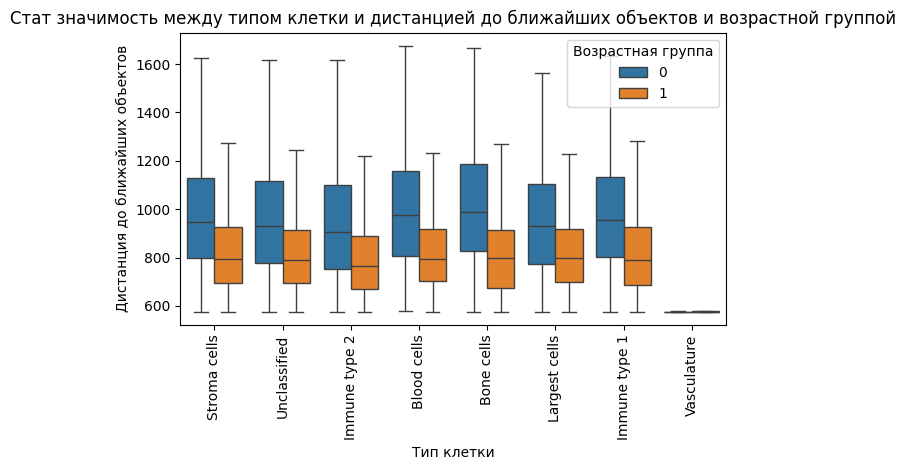

In [51]:
sns.boxplot(
    data= data1,
    x= 'cell_type',
    y= 'distance_to_vasculature',
    hue= 'age_group',
    showfliers= False
)

plt.title('Стат значимость между типом клетки и дистанцией до ближайших объектов и возрастной группой')
plt.xlabel('Тип клетки')
plt.ylabel('Дистанция до ближайших объектов')
plt.legend(title='Возрастная группа')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Средние значения в молодой группе больше чем в возрастной у всех типов клеток. Колонка vasculature неинформативна.

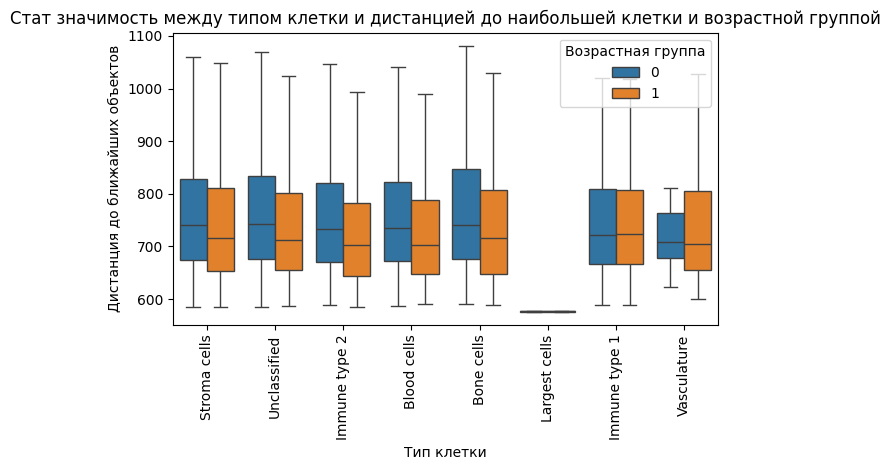

In [52]:
sns.boxplot(
    data= data1,
    x= 'cell_type',
    y= 'distance_to_largest_cell',
    hue= 'age_group',
    showfliers= False
)

plt.title('Стат значимость между типом клетки и дистанцией до наибольшей клетки и возрастной группой')
plt.xlabel('Тип клетки')
plt.ylabel('Дистанция до ближайших объектов')
plt.legend(title='Возрастная группа')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Визуально средние в обеих группах отличаются несильно. Хотя у молодых занчение незначительно больше. largest_cell - неинфоормативная колонкаю

In [53]:
# Создадим сабсеты для каждой возрастной группы и расстояния до ближайших цели

young_distance_to_vasc = data1[data1['age_group'] == 0][['distance_to_vasculature', 'cell_type']]
young_distance_to_vasc = young_distance_to_vasc[young_distance_to_vasc['cell_type'] != 'Vasculature']

young_distance_to_largest = data1[data1['age_group'] == 0][['distance_to_largest_cell', 'cell_type']]
young_distance_to_largest = young_distance_to_largest[young_distance_to_largest['cell_type'] != 'Largest cells']

elder_distance_to_vasc = data1[data1['age_group'] == 1][['distance_to_vasculature', 'cell_type']]
elder_distance_to_vasc = elder_distance_to_vasc[elder_distance_to_vasc['cell_type'] != 'Vasculature']

elder_distance_to_largest = data1[data1['age_group'] == 1][['distance_to_largest_cell', 'cell_type']]
elder_distance_to_largest = elder_distance_to_largest[elder_distance_to_largest['cell_type'] != 'Largest cells']

In [56]:
normality_test(young_distance_to_vasc, 'distance_to_vasculature')

Нулевая гипотеза отвергнута. Распределение Stroma cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Immune type 2 отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Immune type 1 отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Unclassified отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Largest cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Blood cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Bone cells отлично от нормального.


C:\Users\GrafGAD\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [57]:
normality_test(young_distance_to_largest, 'distance_to_largest_cell')

Нулевая гипотеза отвергнута. Распределение Stroma cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Immune type 2 отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Immune type 1 отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Unclassified отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Blood cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Bone cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Vasculature отлично от нормального.


In [58]:
normality_test(elder_distance_to_vasc, 'distance_to_vasculature')

Нулевая гипотеза отвергнута. Распределение Stroma cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Unclassified отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Immune type 2 отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Blood cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Bone cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Largest cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Immune type 1 отлично от нормального.


In [59]:
normality_test(elder_distance_to_largest, 'distance_to_largest_cell')

Нулевая гипотеза отвергнута. Распределение Stroma cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Unclassified отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Immune type 2 отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Blood cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Bone cells отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Immune type 1 отлично от нормального.
Нулевая гипотеза отвергнута. Распределение Vasculature отлично от нормального.


Все данные имеют ненормальное распределение.

In [62]:
homogeneity_test(young_distance_to_vasc, 'distance_to_vasculature')
homogeneity_test(young_distance_to_largest, 'distance_to_largest_cell')
homogeneity_test(elder_distance_to_vasc, 'distance_to_vasculature')
homogeneity_test(elder_distance_to_largest, 'distance_to_largest_cell')

p = 0.05360578100843539
Принята нулевая гипотеза: Распределение гомогенное.
Нулевая гипотеза отвергнута. Распределение отлично от гомогенного.
Нулевая гипотеза отвергнута. Распределение отлично от гомогенного.
Нулевая гипотеза отвергнута. Распределение отлично от гомогенного.


У молодых пациентов данные по расстоянию дл ближайших объектов распределены гомогенно.
В остальных группах распределение негомогенное.

In [63]:
# Размеры выборок
print('Размер молодой выборки и дистанцией до ближайших объектов: {}'.format(young_distance_to_vasc.shape))
print('Размер молодой выборки и дистанцией до наибольшей клетки: {}'.format(young_distance_to_largest.shape))
print('Размер возрастной выборки и дистанцией до ближайших объектов: {}'.format(elder_distance_to_vasc.shape))
print('Размер возрастной выборки и дистанцией до наибольшей клетки: {}'.format(elder_distance_to_largest.shape))


Размер молодой выборки и дистанцией до ближайших объектов: (87620, 2)
Размер молодой выборки и дистанцией до наибольшей клетки: (87147, 2)
Размер возрастной выборки и дистанцией до ближайших объектов: (38783, 2)
Размер возрастной выборки и дистанцией до наибольшей клетки: (38424, 2)


##### Выводы:

Данные распределены ненормально и негомогенно.

Выборки не связаны между собой по возрасту, но связаны по дистанции - данные взяты у одного и тогоже пациента.

Размер выборки достаточный (молодые - от 87147 и возрастные - от 38424)

Имеются выбросы.

Таким образом, нужен непараметрический теста, малочувствительный к выбросам. Тест Краскула-Уолиса.

In [64]:
kruskal_test(young_distance_to_vasc, 'distance_to_vasculature')
kruskal_test(young_distance_to_largest, 'distance_to_largest_cell')
kruskal_test(elder_distance_to_vasc, 'distance_to_vasculature')
kruskal_test(elder_distance_to_largest, 'distance_to_largest_cell')

Нулевая гипотеза отвергнута. Разница между группами статистически значима.
Нулевая гипотеза отвергнута. Разница между группами статистически значима.
Нулевая гипотеза отвергнута. Разница между группами статистически значима.
Нулевая гипотеза отвергнута. Разница между группами статистически значима.


In [65]:
compute_confidence_intervals(young_distance_to_vasc, 'cell_type', 'distance_to_vasculature')

Тип клеток: Stroma cells, 95% доверительный интервал для медианы: [945.47, 950.72]
Тип клеток: Immune type 2, 95% доверительный интервал для медианы: [897.05, 914.65]
Тип клеток: Immune type 1, 95% доверительный интервал для медианы: [942.44, 971.46]
Тип клеток: Unclassified, 95% доверительный интервал для медианы: [928.51, 935.09]
Тип клеток: Largest cells, 95% доверительный интервал для медианы: [902.13, 948.67]
Тип клеток: Blood cells, 95% доверительный интервал для медианы: [956.53, 987.82]
Тип клеток: Bone cells, 95% доверительный интервал для медианы: [972.04, 1001.57]


Доверительные интервалы пересекаются.

In [66]:
compute_confidence_intervals(young_distance_to_largest, 'cell_type', 'distance_to_largest_cell')

Тип клеток: Stroma cells, 95% доверительный интервал для медианы: [739.52, 741.63]
Тип клеток: Immune type 2, 95% доверительный интервал для медианы: [729.67, 738.95]
Тип клеток: Immune type 1, 95% доверительный интервал для медианы: [718.64, 728.36]
Тип клеток: Unclassified, 95% доверительный интервал для медианы: [741.08, 745.46]
Тип клеток: Blood cells, 95% доверительный интервал для медианы: [728.81, 742.26]
Тип клеток: Bone cells, 95% доверительный интервал для медианы: [733.03, 750.54]
Тип клеток: Vasculature, 95% доверительный интервал для медианы: [679.47, 755.17]


Доверительные интервалы пересекаются.

In [67]:
compute_confidence_intervals(elder_distance_to_vasc, 'cell_type', 'distance_to_vasculature')

Тип клеток: Stroma cells, 95% доверительный интервал для медианы: [792.10, 796.48]
Тип клеток: Unclassified, 95% доверительный интервал для медианы: [785.43, 792.60]
Тип клеток: Immune type 2, 95% доверительный интервал для медианы: [758.47, 770.92]
Тип клеток: Blood cells, 95% доверительный интервал для медианы: [770.75, 826.63]
Тип клеток: Bone cells, 95% доверительный интервал для медианы: [744.86, 833.18]
Тип клеток: Largest cells, 95% доверительный интервал для медианы: [783.83, 818.41]
Тип клеток: Immune type 1, 95% доверительный интервал для медианы: [775.66, 804.57]


Доверительные интервалы пересекаются.

In [68]:
compute_confidence_intervals(elder_distance_to_largest, 'cell_type', 'distance_to_largest_cell')

Тип клеток: Stroma cells, 95% доверительный интервал для медианы: [715.16, 718.48]
Тип клеток: Unclassified, 95% доверительный интервал для медианы: [710.08, 715.57]
Тип клеток: Immune type 2, 95% доверительный интервал для медианы: [698.85, 706.25]
Тип клеток: Blood cells, 95% доверительный интервал для медианы: [686.10, 717.26]
Тип клеток: Bone cells, 95% доверительный интервал для медианы: [695.82, 734.74]
Тип клеток: Immune type 1, 95% доверительный интервал для медианы: [719.70, 731.42]
Тип клеток: Vasculature, 95% доверительный интервал для медианы: [687.54, 754.13]


Доверительные интервалы пересекаются.

Сделай обший вывод

#### Задача 2

В каком клеточном микроокружении клеток какого типа статистически больше, чем в других микроокружениях? (колонка cell_interaction). Для ответа используйте box_plot/swarplot с hue по микроокружениям, где:

 - по Ох будут типы клеток,
 - по Оу — их количество.

 Не забудьте посчитать количество для каждого пациента отдельно, иначе выборка не будет репрезентативной.

In [69]:
data2 = dataset.copy()

In [70]:
data2.head()

,distance_to_vasculature,distance_to_largest_cell,immune_marker_1,immune_marker_2,cell_interaction,cell_type,case_id,area_of_cell,age_group,cell_interaction_digit
0,988.509380,612.076506,10.803755,187.998971,community_1,Stroma cells,891.0,185.0,1,1
1,787.852379,637.787202,11.749179,155.357076,community_1,Stroma cells,891.0,209.0,1,1
2,960.635580,700.283468,15.124372,182.626888,community_2,Stroma cells,891.0,254.0,1,2
3,702.033032,676.409695,14.221883,158.381917,community_3,Unclassified,891.0,156.0,1,3
4,830.399371,863.269930,19.978977,159.071269,community_3,Unclassified,891.0,194.0,1,3


In [72]:
data2['case_id'] = data2['case_id'].astype('int64')


data2['case_id'].value_counts()

case_id
693    32656
40     24109
983    23023
199    21278
708    10687
566     6548
891     4327
559     3845
Name: count, dtype: int64

In [76]:
cell_counts = data2.groupby(
    ['case_id', 'cell_type', 'cell_interaction_digit']).size().reset_index(name='count')

# Получение уникальных категорий микроокружения
interaction_communities = sorted(
    cell_counts['cell_interaction_digit'].unique())

C:\Users\GrafGAD\AppData\Roaming\Python\Python311\site-packages\seaborn\categorical.py:3370: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\GrafGAD\AppData\Roaming\Python\Python311\site-packages\seaborn\categorical.py:3370: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\GrafGAD\AppData\Roaming\Python\Python311\site-packages\seaborn\categorical.py:3370: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\GrafGAD\AppData\Roaming\Python\Python311\site-packages\seaborn\categorical.py:3370: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\GrafGAD\App

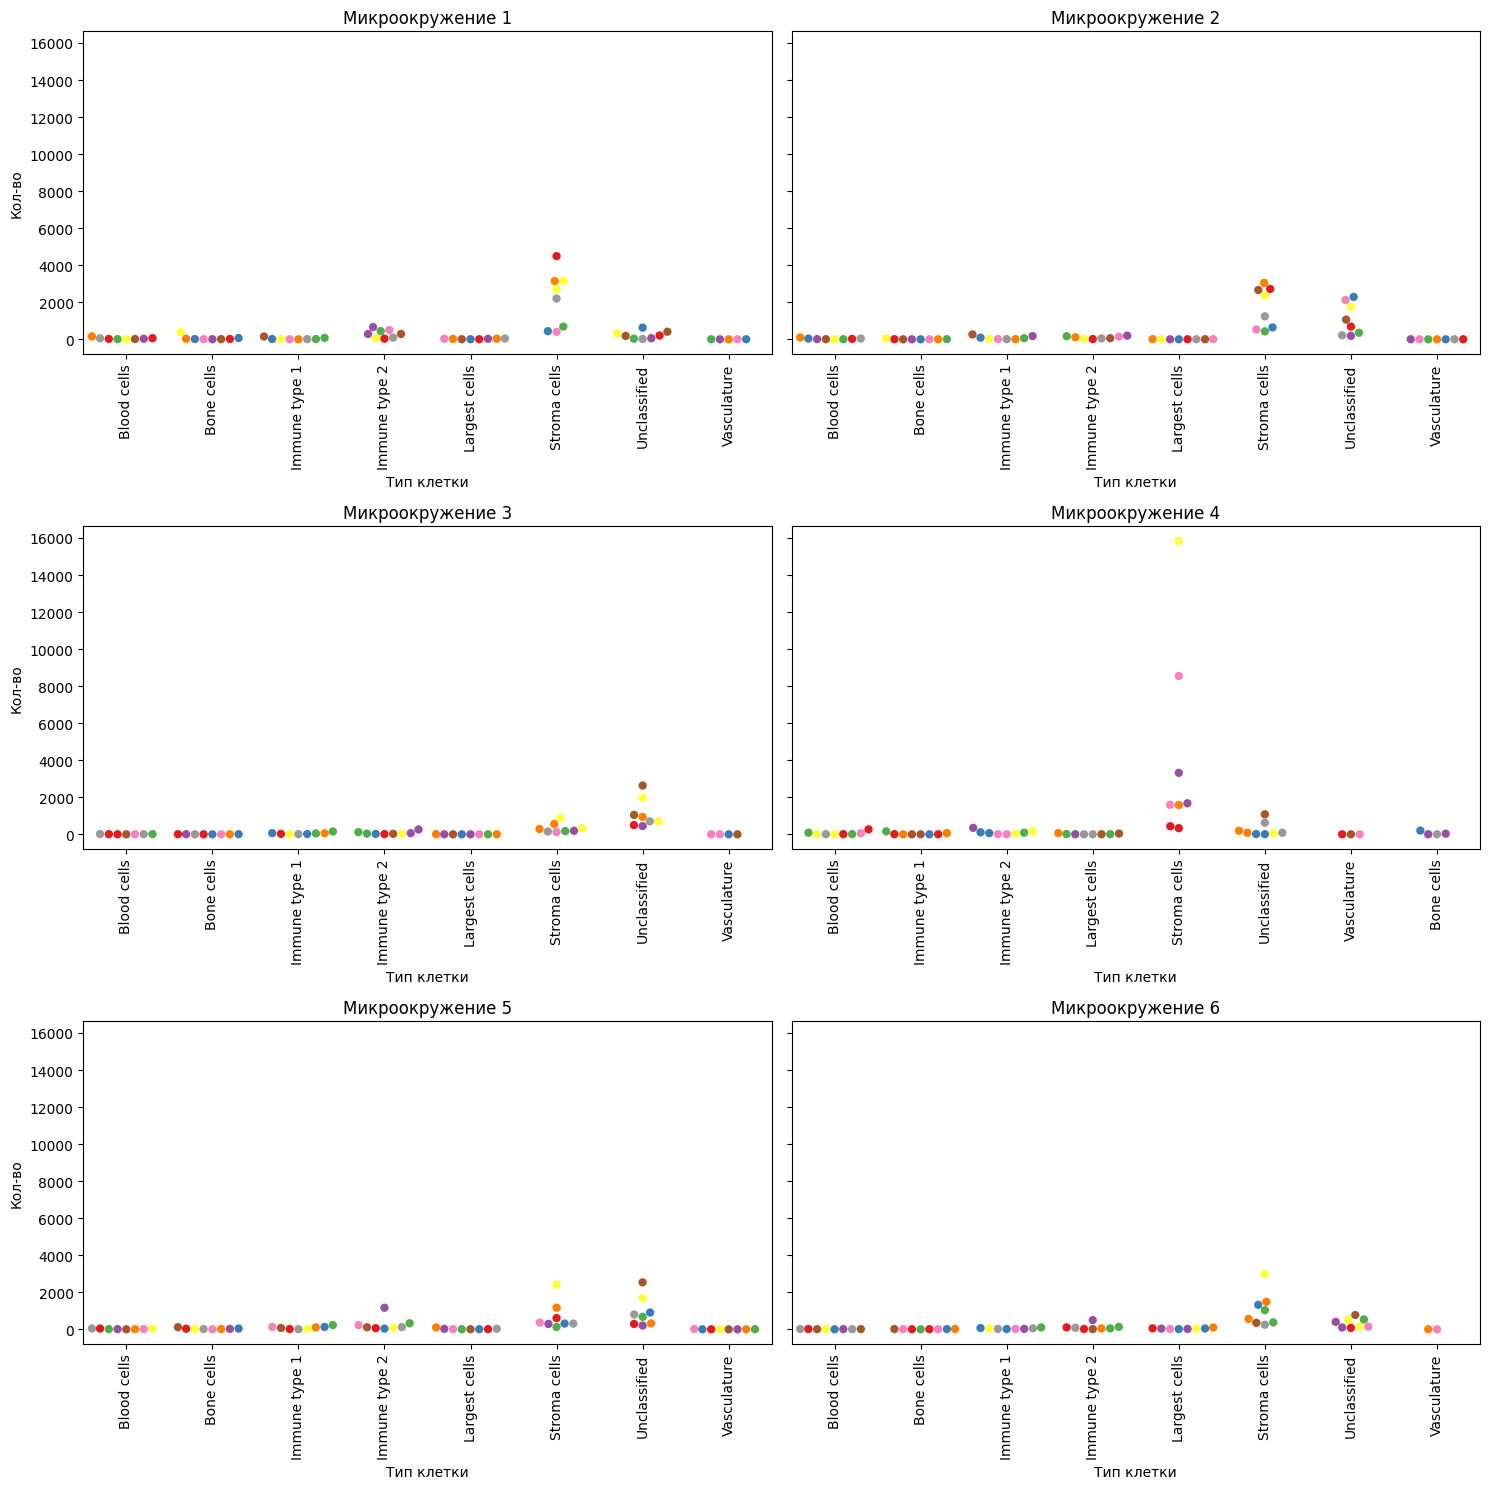

In [78]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), sharey=True)
# Итерация по категориям микроокружения и их индексам, создание swarmplot для каждой
for i, community in enumerate(interaction_communities):
    row = i // 2
    col = i % 2
    community_data = cell_counts[cell_counts['cell_interaction_digit'] == community]
    ax = axes[row, col]
    sns.swarmplot(ax=ax, x='cell_type', y='count', data=community_data,
                  hue=community_data.index, palette='Set1', size=6)
    ax.set_title(f'Микроокружение {community}')
    ax.set_xlabel('Тип клетки')
    ax.set_ylabel('Кол-во')
    ax.tick_params(axis='x', labelrotation=90)
    ax.get_legend().remove()

# Настройка макета, чтобы предотвратить перекрытие элементов графика
plt.tight_layout()
plt.show()

Во всех микроокружениях преобладают стромальные клетки, кроме 3.

В микроокружениях 1, 4, 6 преобладают стромальные клетки.
В микроокружении 2 и 5 преобладают стромальные и неклассифицированные клетки.
В 3 микроокружении преобладают неклассифицированные клетки.


C:\Users\GrafGAD\AppData\Local\Temp\ipykernel_4344\3220441905.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
C:\Users\GrafGAD\AppData\Local\Temp\ipykernel_4344\3220441905.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
C:\Users\GrafGAD\AppData\Local\Temp\ipykernel_4344\3220441905.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
C:\Users\GrafGAD\AppData\Local\Temp\ipykernel_4344\3220441905.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_

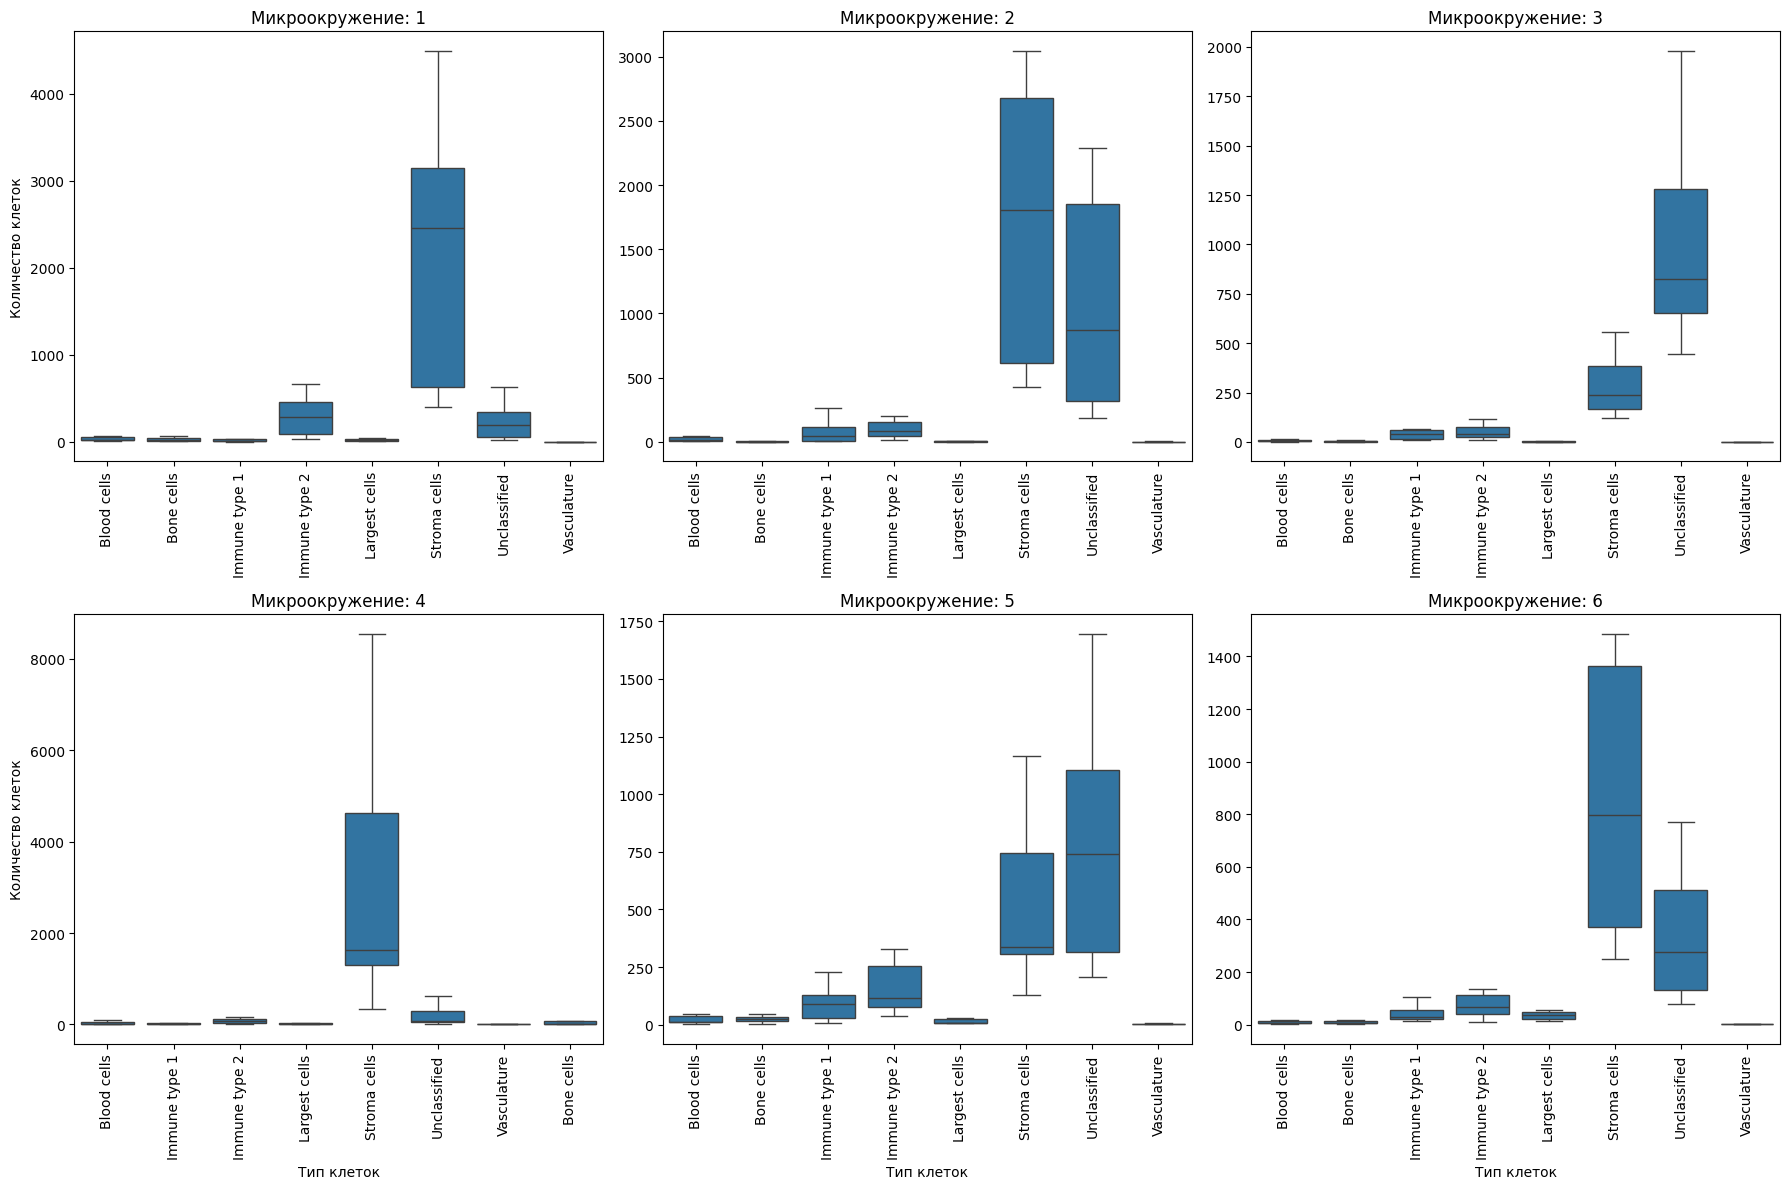

In [81]:
# Cетка из 6 графиков
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, community in enumerate(interaction_communities):
    data = cell_counts[cell_counts['cell_interaction_digit'] == community]

    sns.boxplot(x='cell_type', y='count', data=data,
                showfliers=False, ax=axes[i])
    axes[i].set_title(f'Микроокружение: {community}')

    # Название оси Х для первой колонки графиков
    if i % 3 == 0:
        axes[i].set_ylabel('Количество клеток')
    else:
        axes[i].set_ylabel('')

    # Название оси Y для нижней колонки линии графиков
    if i >= len(interaction_communities) - 3:
        axes[i].set_xlabel('Тип клеток')
    else:
        axes[i].set_xlabel('')

    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

Результат boxplot сопоставим c swarplot